Normal Imports

In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline

from tensorboard.plugins.hparams import api as hp
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend


Insuring that gpu is being used

In [2]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.10.1
Num GPUs Available:  1


In [28]:
from src.extract_to_df import extract_to_df
from src.metric_notes import metric_note

In [4]:
#prevent a bug that some images are truncated
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


Normal data extraction

In [5]:
test = Path('Data/test')
train = Path('Data/train')
valid = Path('Data/valid')


In [6]:
train_df = extract_to_df(train, 'Train')
test_df = extract_to_df(test, 'Test')
val_df = extract_to_df(valid,'Valid')

In [7]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_generator = ImageDataGenerator(
    rescale=1./255
)


Setting the size of image

In [8]:
pixel = 64
size = f'{pixel}x{pixel}'

In [9]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                   x_col='Path',
                                                   y_col='Label',
                                                   target_size=(pixel, pixel),
                                                   class_mode='binary',
                                                   color_mode='rgb',
                                                   shuffle=True,
                                                   seed=42,
                                                   batch_size=128)

valid_images = train_generator.flow_from_dataframe(dataframe=val_df,
                                                   x_col='Path',
                                                   y_col='Label',
                                                   target_size=(pixel, pixel),
                                                   class_mode='binary',
                                                   color_mode='rgb',
                                                   shuffle=True,
                                                   seed=42,
                                                   batch_size=64)

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='Path',
                                                 y_col='Label',
                                                 target_size=(pixel, pixel),
                                                 class_mode='binary',
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 seed=42,
                                                 batch_size=128)

Found 30250 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.


Creating an object to store the evaulations

In [29]:
metrics = metric_note(train_images, test_images, valid_images)

In [11]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_LEARNING = hp.HParam('learning', hp.Discrete([0.001, 0.005,0.0001]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_LEARNING],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [12]:
def create_model(hparams):
    cnn4 = Sequential([
        Conv2D(hparams[HP_NUM_UNITS], kernel_size =(3,3) , activation = 'relu', input_shape=(pixel, pixel, 3)),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),
        Dropout(hparams[HP_DROPOUT]),
        Conv2D(hparams[HP_NUM_UNITS]*2, kernel_size =(3,3) , activation = 'relu', input_shape=(pixel, pixel, 3)),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),
        Dropout(hparams[HP_DROPOUT]),
        Conv2D(hparams[HP_NUM_UNITS]*3, kernel_size =(3,3) , activation = 'relu', input_shape=(pixel, pixel, 3)),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),
        Dropout(hparams[HP_DROPOUT]),
        Conv2D(hparams[HP_NUM_UNITS]*4, kernel_size =(3,3) , activation = 'relu', input_shape=(pixel, pixel, 3)),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),
        Dropout(hparams[HP_DROPOUT]*4),
        Flatten(),
        Dense(hparams[HP_NUM_UNITS], activation = 'relu'),
        BatchNormalization(),
        Dropout(hparams[HP_DROPOUT]),
        Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING])
    cnn4.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy'])
    
    cnn4.fit(train_images,
            batch_size=64,
            epochs=10)
    _, accuracy = cnn4.evaluate(test_images)
    return accuracy


In [13]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  
    accuracy = create_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [14]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for learning in HP_LEARNING.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_LEARNING: learning,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'learning': 0.0001}
Epoch 1/10
237/237 [==============================] - 294s 1s/step - loss: 0.3040 - accuracy: 0.8773
Epoch 2/10
237/237 [==============================] - 59s 248ms/step - loss: 0.2484 - accuracy: 0.9014
Epoch 3/10
237/237 [==============================] - 60s 252ms/step - loss: 0.2301 - accuracy: 0.9076
Epoch 4/10
237/237 [==============================] - 59s 248ms/step - loss: 0.2118 - accuracy: 0.9155
Epoch 5/10
237/237 [==============================] - 60s 252ms/step - loss: 0.2059 - accuracy: 0.9192
Epoch 6/10
237/237 [==============================] - 59s 248ms/step - loss: 0.1968 - accuracy: 0.9226
Epoch 7/10
237/237 [==============================] - 59s 249ms/step - loss: 0.1936 - accuracy: 0.9233
Epoch 8/10
237/237 [==============================] - 59s 249ms/step - loss: 0.1888 - accuracy: 0.9246
Epoch 9/10
237/237 [==============================] - 58s 247ms/step - loss: 0.1794 - accuracy: 0.

Lets look at the tensorboard to see what hyperparameters performed the best

There were three set of hyperparameters that performed well. 
1. 32 nodes, 0.1 dropout, 0.001 learning rate produced a 96.619%
2. 16 nodes, 0.2 dropout, 0.005 learning rate produced a 95.429%
3. 32 nodes, 0.1 dropout, 0.0001 learning rate produced a 95.111%

I will test these three versions of model and see which one performs better on the test data

<hr style="border:2px solid magenta">  

Onto running these three models. 

In [17]:
import datetime


def create_log_path(name):
    log_dir = "logs/fit/" + f'{name}/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    return log_dir

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True)


In [19]:
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives

def create_model_2(node, dropout, learning):
    cnn4 = Sequential([
        Conv2D(node, kernel_size =(3,3) , activation = 'relu', input_shape=(pixel, pixel, 3)),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),
        Dropout(dropout),
        Conv2D(node*2, kernel_size =(3,3) , activation = 'relu', input_shape=(pixel, pixel, 3)),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),
        Dropout(dropout),
        Conv2D(node*3, kernel_size =(3,3) , activation = 'relu', input_shape=(pixel, pixel, 3)),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),
        Dropout(dropout),
        Conv2D(node*4, kernel_size =(3,3) , activation = 'relu', input_shape=(pixel, pixel, 3)),
        MaxPooling2D(pool_size=2),
        BatchNormalization(),
        Dropout(dropout*4),
        Flatten(),
        Dense(node, activation = 'relu'),
        BatchNormalization(),
        Dropout(dropout),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning)
    cnn4.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', TruePositives(thresholds= .5), TrueNegatives(thresholds= .5), FalsePositives(thresholds= .5), FalseNegatives(thresholds= .5)])
    return cnn4

In [20]:
model1 = create_model_2(32, 0.1, 0.001)

results1 = model1.fit(train_images,
                    batch_size = 64, 
                    epochs = 1000,
                    validation_data = valid_images,
                    callbacks = [early_stop, 
                                tf.keras.callbacks.TensorBoard(log_dir=create_log_path('CNN4_best'), histogram_freq=1)],
                    workers = 10)

Epoch 1/1000
237/237 [==============================] - 58s 233ms/step - loss: 0.2239 - accuracy: 0.9101 - true_positives: 14536.0000 - true_negatives: 12995.0000 - false_positives: 1505.0000 - false_negatives: 1214.0000 - val_loss: 0.6685 - val_accuracy: 0.6290 - val_true_positives: 3480.0000 - val_true_negatives: 483.0000 - val_false_positives: 2337.0000 - val_false_negatives: 0.0000e+00
Epoch 2/1000
237/237 [==============================] - 22s 90ms/step - loss: 0.1786 - accuracy: 0.9300 - true_positives: 14797.0000 - true_negatives: 13337.0000 - false_positives: 1163.0000 - false_negatives: 953.0000 - val_loss: 0.5849 - val_accuracy: 0.7767 - val_true_positives: 3475.0000 - val_true_negatives: 1418.0000 - val_false_positives: 1402.0000 - val_false_negatives: 5.0000
Epoch 3/1000
237/237 [==============================] - 22s 89ms/step - loss: 0.1668 - accuracy: 0.9333 - true_positives: 14884.0000 - true_negatives: 13347.0000 - false_positives: 1153.0000 - false_negatives: 866.0000 

99/99 [==============================] - 14s 140ms/step - loss: 0.0606 - accuracy: 0.9779 - true_positives: 3407.0000 - true_negatives: 2754.0000 - false_positives: 66.0000 - false_negatives: 73.0000


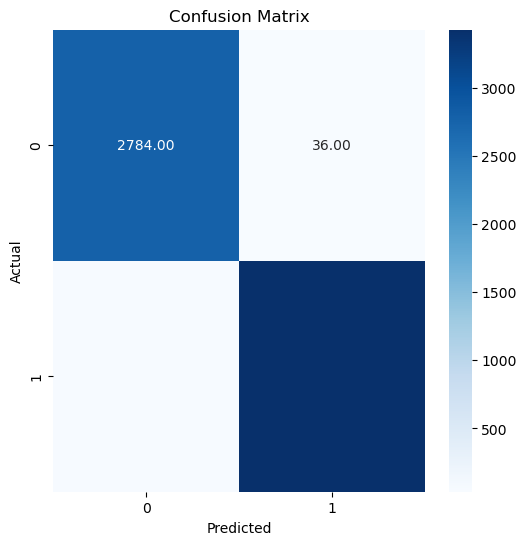

In [30]:
metrics.evaluate(model1, 'CNN 4 Best', size)

WOW extremely low false negatives and false negatives. 98.54% accuracy. That is pretty good!!!

In [23]:
model2 = create_model_2(16, 0.2, 0.005)

results2 = model2.fit(train_images,
                    batch_size = 64, 
                    epochs = 1000,
                    validation_data = valid_images,
                    callbacks = [early_stop, 
                                tf.keras.callbacks.TensorBoard(log_dir=create_log_path('CNN4_second'), histogram_freq=1)],
                    workers = 10)

Epoch 1/1000
237/237 [==============================] - 24s 94ms/step - loss: 0.2520 - accuracy: 0.8991 - true_positives_1: 14569.0000 - true_negatives_1: 12628.0000 - false_positives_1: 1872.0000 - false_negatives_1: 1181.0000 - val_loss: 0.3282 - val_accuracy: 0.8844 - val_true_positives_1: 3429.0000 - val_true_negatives_1: 2143.0000 - val_false_positives_1: 677.0000 - val_false_negatives_1: 51.0000
Epoch 2/1000
237/237 [==============================] - 23s 92ms/step - loss: 0.2056 - accuracy: 0.9182 - true_positives_1: 14729.0000 - true_negatives_1: 13047.0000 - false_positives_1: 1453.0000 - false_negatives_1: 1021.0000 - val_loss: 0.2577 - val_accuracy: 0.8895 - val_true_positives_1: 3455.0000 - val_true_negatives_1: 2149.0000 - val_false_positives_1: 671.0000 - val_false_negatives_1: 25.0000
Epoch 3/1000
237/237 [==============================] - 22s 90ms/step - loss: 0.1875 - accuracy: 0.9268 - true_positives_1: 14784.0000 - true_negatives_1: 13251.0000 - false_positives_1: 124

99/99 [==============================] - 13s 133ms/step - loss: 0.0893 - accuracy: 0.9684 - true_positives_1: 3385.0000 - true_negatives_1: 2716.0000 - false_positives_1: 104.0000 - false_negatives_1: 95.0000


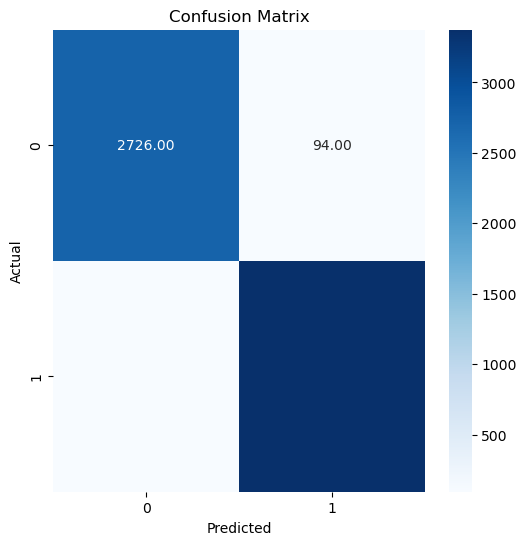

In [31]:
metrics.evaluate(model2, 'CNN 4 Second', size)

In [25]:
model3 = create_model_2(32, 0.1, 0.0001)

results3 = model3.fit(train_images,
                    batch_size = 64, 
                    epochs = 1000,
                    validation_data = valid_images,
                    callbacks = [early_stop, 
                                tf.keras.callbacks.TensorBoard(log_dir=create_log_path('CNN4_third'), histogram_freq=1)],
                    workers = 10)

Epoch 1/1000
237/237 [==============================] - 23s 90ms/step - loss: 0.2703 - accuracy: 0.8903 - true_positives_2: 14186.0000 - true_negatives_2: 12745.0000 - false_positives_2: 1755.0000 - false_negatives_2: 1564.0000 - val_loss: 0.5580 - val_accuracy: 0.6641 - val_true_positives_2: 3479.0000 - val_true_negatives_2: 705.0000 - val_false_positives_2: 2115.0000 - val_false_negatives_2: 1.0000
Epoch 2/1000
237/237 [==============================] - 22s 90ms/step - loss: 0.2125 - accuracy: 0.9155 - true_positives_2: 14552.0000 - true_negatives_2: 13143.0000 - false_positives_2: 1357.0000 - false_negatives_2: 1198.0000 - val_loss: 0.6216 - val_accuracy: 0.7216 - val_true_positives_2: 3480.0000 - val_true_negatives_2: 1066.0000 - val_false_positives_2: 1754.0000 - val_false_negatives_2: 0.0000e+00
Epoch 3/1000
237/237 [==============================] - 22s 90ms/step - loss: 0.1931 - accuracy: 0.9215 - true_positives_2: 14614.0000 - true_negatives_2: 13260.0000 - false_positives_2: 

99/99 [==============================] - 14s 136ms/step - loss: 0.0707 - accuracy: 0.9744 - true_positives_2: 3425.0000 - true_negatives_2: 2714.0000 - false_positives_2: 106.0000 - false_negatives_2: 55.0000


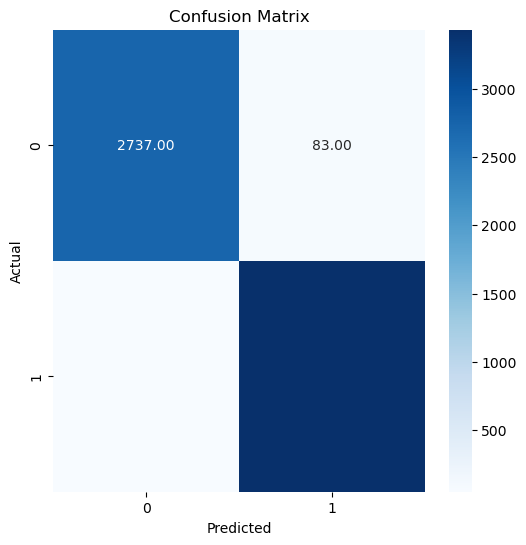

In [32]:
metrics.evaluate(model3, 'CNN 4 Third', size)

In [48]:
metrics.printout

,Model,Size,train log_loss,train accuracy,train TP,train TN,train FP,train FN,test log_loss,test accuracy,test TP,test TN,test FP,test FN,val log_loss,val accuracy,val TP,val TN,val FP,val FN
0,CNN 4 Best,64x64,0.038952,0.985223,15533.0,14270.0,230.0,217.0,0.039796,0.985397,3424.0,2784.0,36.0,56.0,0.060555,0.977937,3407.0,2754.0,66.0,73.0
1,CNN 4 Second,64x64,0.098321,0.962843,15358.0,13768.0,732.0,392.0,0.087879,0.968254,3374.0,2726.0,94.0,106.0,0.089328,0.968413,3385.0,2716.0,104.0,95.0
2,CNN 4 Third,64x64,0.072675,0.973322,15609.0,13834.0,666.0,141.0,0.055510,0.979048,3431.0,2737.0,83.0,49.0,0.070660,0.974444,3425.0,2714.0,106.0,55.0


In [46]:
model1.save_weights('./Models/CNN4_best')
model2.save_weights('./Models/CNN4_second')
model3.save_weights('./Models/CNN4_third')

Saving the weights of the models for future use. 

In [47]:
metrics.printout.to_csv(f'Dataframes/{size}Tuning_CNN4.csv')